In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model

import os
import glob
import shutil

from pathlib import Path

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [8]:
# Define path to the data directory
data_dir = Path('../input/shai-level-2-training')

# Path to train directory
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

In [9]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'normal'
virus_cases_dir = train_dir / 'virus'
covid_cases_dir = train_dir / 'covid'

# Get the list of all the images
# jpeg, png, jpg
covid_cases = covid_cases_dir.glob('*g' )
normal_cases = normal_cases_dir.glob('*g')
virus_cases = virus_cases_dir.glob('*g')
train = {}
for i in ['covid', 'normal', 'virus']:
    train[i] = glob.glob("../input/shai-level-2-training/train/{}/*g".format(i))
    
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 0))

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,1))

# Go through all the virus cases. The label for these cases will be 1
for img in virus_cases:
    train_data.append((img, 2))
    

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,../input/shai-level-2-training/train/normal/53...,1
1,../input/shai-level-2-training/train/normal/57...,1
2,../input/shai-level-2-training/train/normal/12...,1
3,../input/shai-level-2-training/train/covid/787...,0
4,../input/shai-level-2-training/train/normal/46...,1


In [10]:
train = pd.read_csv("../input/shai-level-2-training/train.csv")
train.head()

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal


In [11]:
for i in range(train.shape[0]):
    train.loc[i,'Image'] = "../input/shai-level-2-training/train/" + train.loc[i,'Label'] + "/" + train.loc[i,'Image']

In [12]:
from sklearn.preprocessing import LabelEncoder
Ln=LabelEncoder().fit(train['Label'])

1    468
2    433
0    295
Name: label, dtype: int64


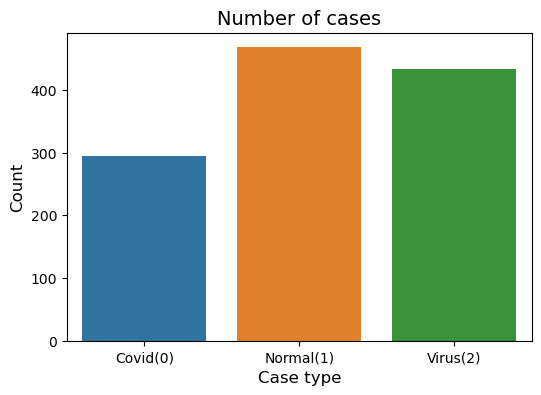

In [13]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(6,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Covid(0)','Normal(1)','Virus(2)'])
plt.show()

In [14]:
covid_samples = (train_data[train_data['label']==0]['image'].iloc[:10]).tolist()
normal_samples = (train_data[train_data['label']==1]['image'].iloc[:10]).tolist()
virus_samples = (train_data[train_data['label']==2]['image'].iloc[:10]).tolist()

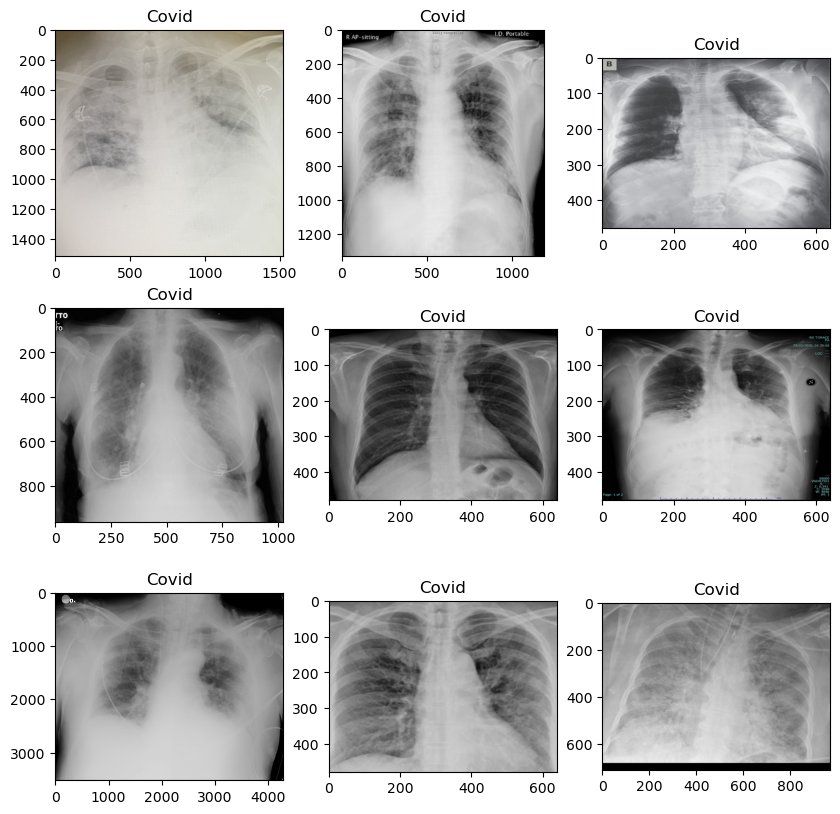

In [15]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(covid_samples[i]),cmap='gray')
    plt.title("Covid")
plt.show()

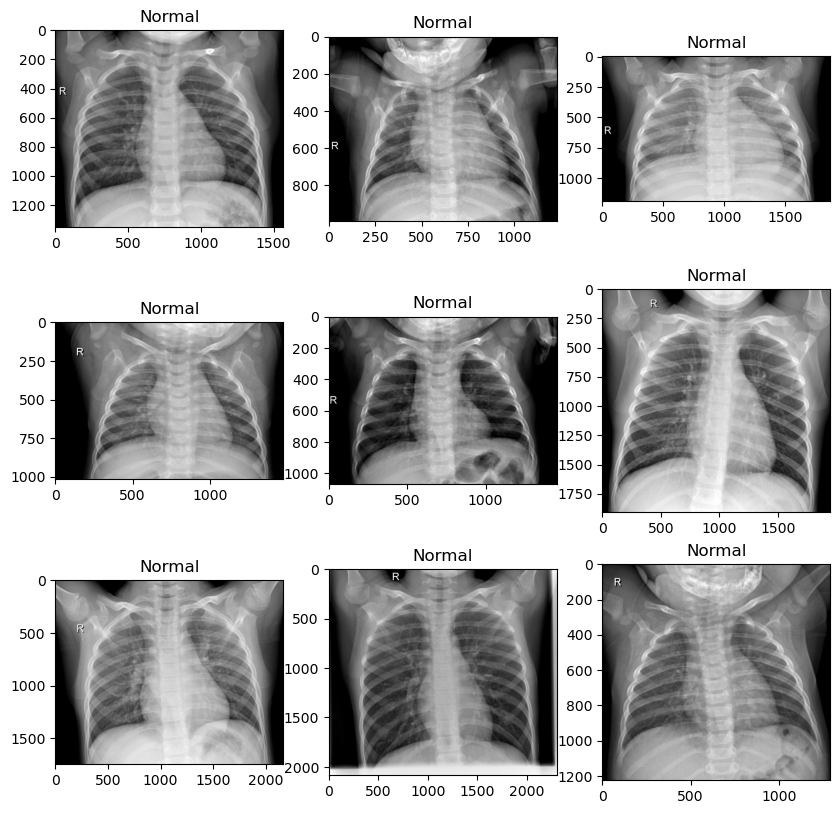

In [17]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(normal_samples[i]),cmap='gray')
    plt.title("Normal")
plt.show()

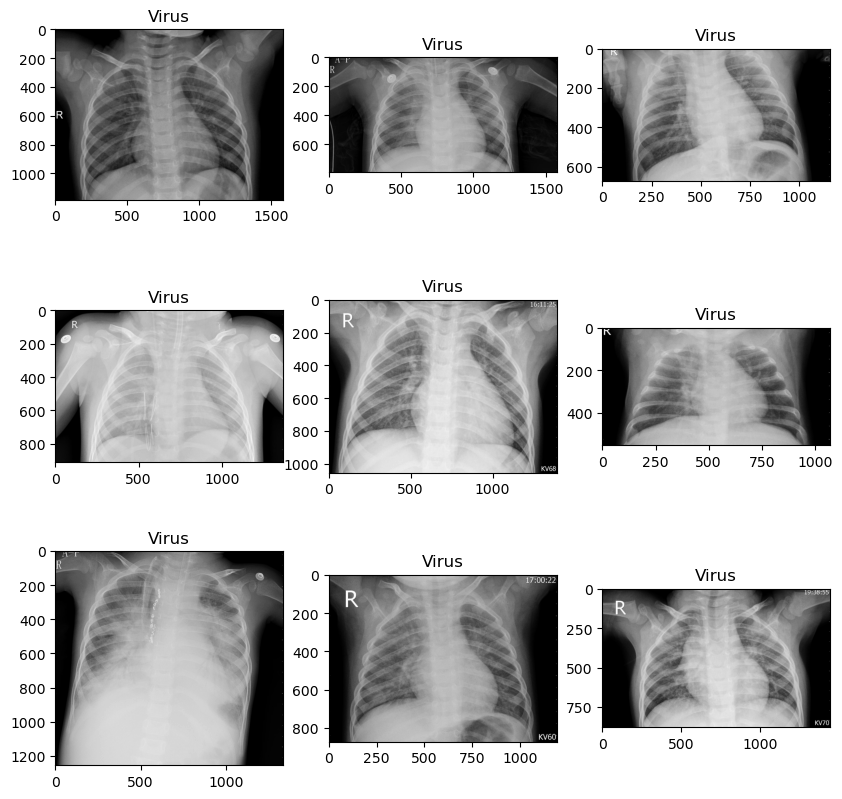

In [16]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(virus_samples[i]),cmap='gray')
    plt.title("Virus")
plt.show()

In [17]:
image_size = 224 
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=15,
        fill_mode="nearest")


training_set = train_datagen.flow_from_directory(train_dir,
                                                 subset='training',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                  seed=42,
                                                 shuffle=True)

validation_set = train_datagen.flow_from_directory(train_dir,
    subset='validation',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',seed=42,
    shuffle=True)


Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.


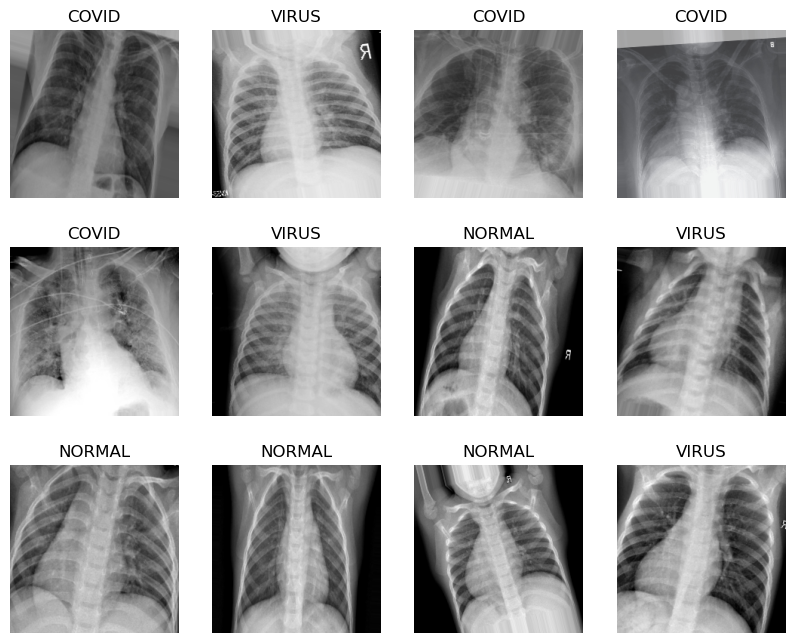

In [21]:
labels = ['COVID', 'NORMAL', 'VIRUS']

sample_data = training_set.__getitem__(0)[0] 
sample_label = training_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [26]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [25]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.0001, patience=3, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)

In [4]:
# Building the Convolutional Neural Network with Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model3 = Sequential()
model3.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(image_size,image_size,3)))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 256)               1

In [9]:
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())

In [8]:
history =model3.fit_generator(training_set,epochs=7,validation_data=validation_set)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/7
15/15 [==============================] - 144s 9s/step - loss: 4.3346 - accuracy: 0.3862 - val_loss: 1.0052 - val_accuracy: 0.4916
Epoch 2/7
15/15 [==============================] - 139s 9s/step - loss: 0.8448 - accuracy: 0.6127 - val_loss: 0.7606 - val_accuracy: 0.6471
Epoch 3/7
15/15 [==============================] - 137s 9s/step - loss: 0.6624 - accuracy: 0.7203 - val_loss: 0.6337 - val_accuracy: 0.7395
Epoch 4/7
15/15 [==============================] - 137s 9s/step - loss: 0.5335 - accuracy: 0.7808 - val_loss: 0.5533 - val_accuracy: 0.8067
Epoch 5/7
15/15 [==============================] - 138s 9s/step - loss: 0.4746 - accuracy: 0.8027 - val_loss: 0.5999 - val_accuracy: 0.7437
Epoch 6/7
15/15 [==============================] - 137s 9s/step - loss: 0.4529 - accuracy: 0.8058 - val_loss: 0.4244 - val_accuracy: 0.8529
Epoch 7/7
15/15 [==============================] - 137s 9s/step - loss: 0.3820 - accuracy: 0.8653 - val_loss: 0.3497 - val_accuracy: 0.8613


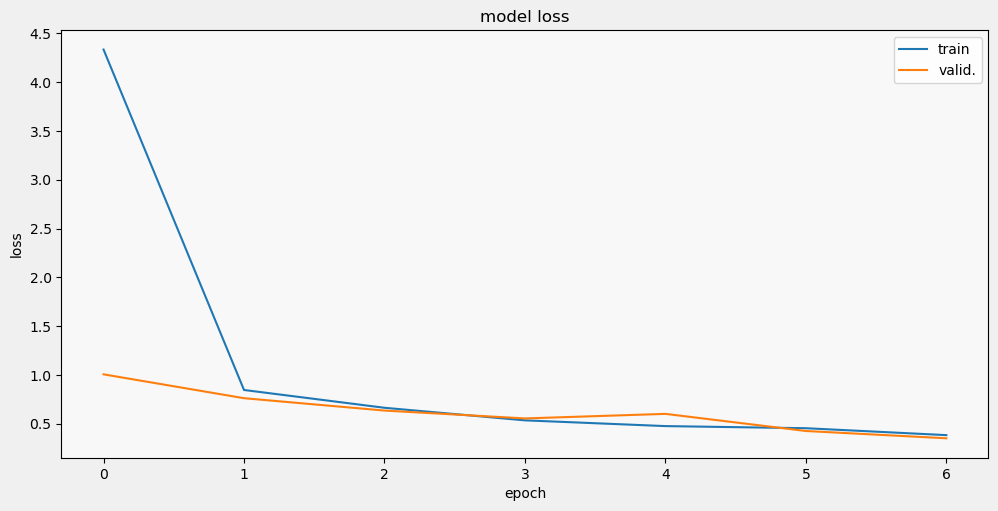

In [16]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)

In [5]:
import tensorflow as tf 
pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [34]:

x1 = pretrained_vgg.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
# model_vgg.summary()

In [24]:
his =model_vgg.fit(training_set,epochs=10,batch_size = BATCH_SIZE,validation_data=validation_set,callbacks=[lr_reduce, es_callback])

Epoch 1/10
15/15 [==============================] - 242s 16s/step - loss: 1.0021 - accuracy: 0.5240 - val_loss: 0.5958 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 239s 16s/step - loss: 0.5757 - accuracy: 0.7735 - val_loss: 0.4067 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 237s 16s/step - loss: 0.4292 - accuracy: 0.8580 - val_loss: 0.3153 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 254s 17s/step - loss: 0.3640 - accuracy: 0.8841 - val_loss: 0.3275 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 239s 16s/step - loss: 0.3144 - accuracy: 0.9008 - val_loss: 0.2680 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - 236s 16s/step - loss: 0.2933 - accuracy: 0.9092 - val_loss: 0.2617 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 7/10
15/15 [==============================] - 235s 16s/step - lo

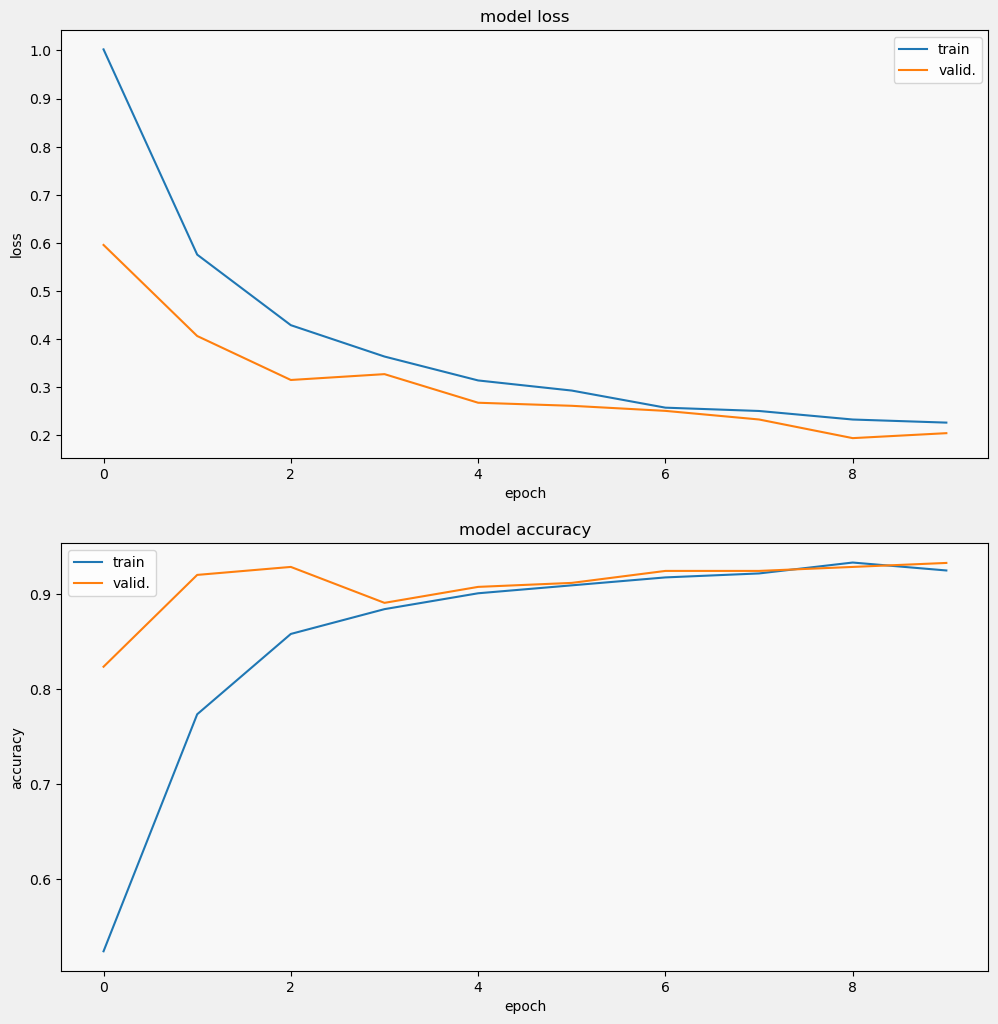

In [27]:
display_training_curves(his.history['loss'], his.history['val_loss'], 'loss', 211)
display_training_curves(his.history['accuracy'], his.history['val_accuracy'], 'accuracy', 212)

In [33]:
df=pd.read_csv('../input/shai-level-2-training/sample_submission.csv')

In [18]:
import cv2
for i in os.listdir('../input/shai-level-2-training/test'):
    x = cv2.imread('../input/shai-level-2-training/test/'+i, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (224, 224))
    x=x/255
    x=np.expand_dims(x,axis=0)
    predict=model_densenet.predict(x)
    df['Label'][df['Image']==i]=str(Ln.inverse_transform([np.argmax(predict)])[0])

In [35]:
df.to_csv('wesam2.csv',index=False)

In [30]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
    layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.55, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())
# model_densenet.summary()

In [31]:
history_densenet =model_densenet.fit_generator(training_set,epochs=7,validation_data=validation_set,callbacks=[lr_reduce, es_callback])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/7
15/15 [==============================] - 48s 3s/step - loss: 1.8891 - accuracy: 0.6086 - val_loss: 0.6585 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 2/7
15/15 [==============================] - 33s 2s/step - loss: 0.4224 - accuracy: 0.8361 - val_loss: 0.2857 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 3/7
15/15 [==============================] - 33s 2s/step - loss: 0.3215 - accuracy: 0.8852 - val_loss: 0.2694 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 4/7
15/15 [==============================] - 33s 2s/step - loss: 0.2948 - accuracy: 0.9040 - val_loss: 0.2501 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 5/7
15/15 [==============================] - 32s 2s/step - loss: 0.2926 - accuracy: 0.8914 - val_loss: 0.2433 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 6/7
15/15 [==============================] - 33s 2s/step - loss: 0.2189 - accuracy: 0.9207 - val_loss: 0.2700 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 7/7
15/15 [==============================] - 33s 2s/step - loss: 0.2127 - accuracy

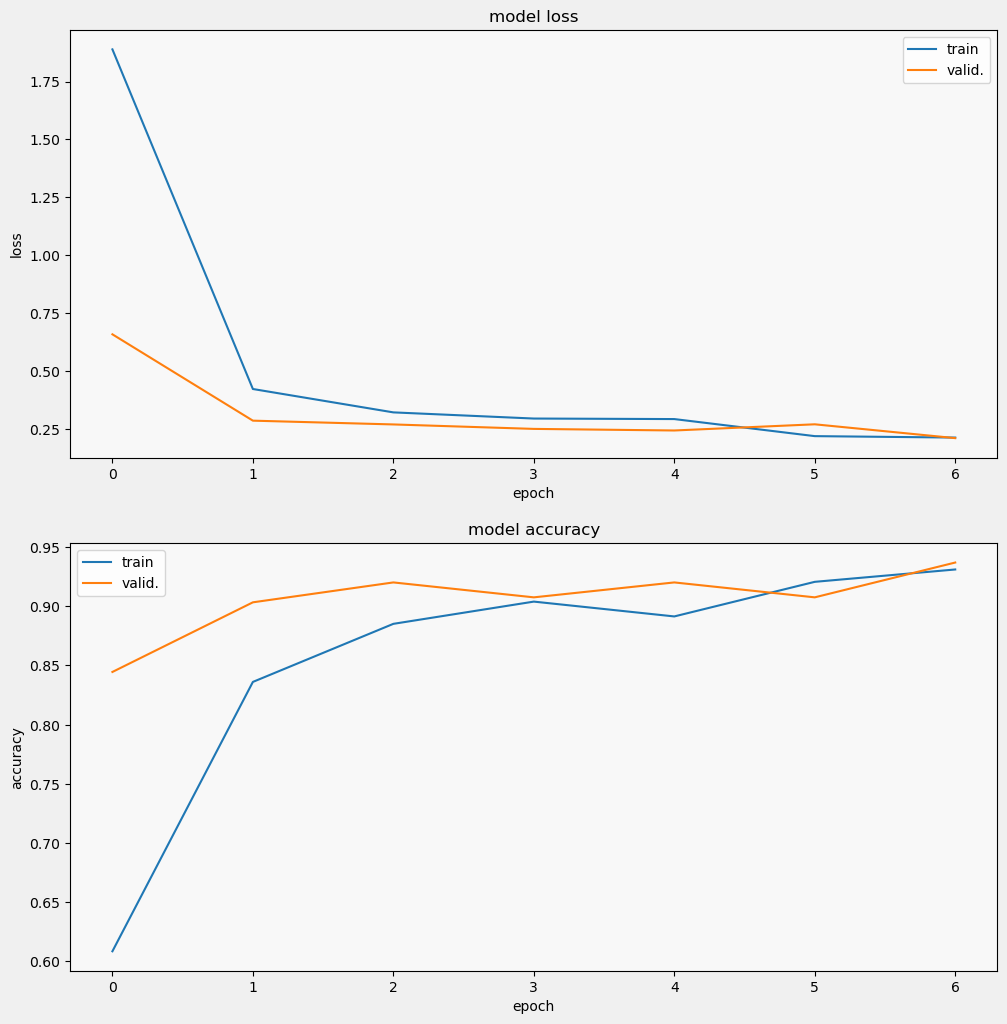

In [32]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'],history_densenet.history['val_accuracy'], 'accuracy', 212)